In [39]:
import matplotlib.pyplot as plt
import numpy as np
import fiona
import geopandas as gpd
import contextily as cx
import pandas as pd

# Obtain the coordinates for the OS's 10km grid
First download the OSGB grid squares from OS's repo (https://github.com/OrdnanceSurvey/OS-British-National-Grids)
Extract the .7z file to reveal the geopakace (.gpkg) file.

In this example, we are going to use the 4 digit map tile name for the OSGB's 10km grid squares. 
In order to work out which point data are observed in each square, we need to get the bounding coordinates. These are contained within a Shapely geometry (Polygon) object for each square (constrained by five X,Y position pairs, one for each vertex of the square and a repeat of the first coordinate again to close the polygon).

The OSGB coordinate reference system (crs) in is EPSG:27700, we want to transform this to epsg:3857, along with the point data for further analysis:

In [2]:
_filename = '../Mapping/OS-British-National-Grids-main/os_bng_grids.gpkg'

#N.B. to get a list of the included layer names, can use: 
# fiona.listlayers(_filename)

# Let's load the data:
OS10kmCoordinates = gpd.read_file(_filename,layer='10km_grid',crs="EPSG:27700")

# # To swap the crs, we first need to make a new geopandas dataframe, instantiated with the current crs
OS10kmCoordinates = gpd.GeoDataFrame(OS10kmCoordinates, columns=['tile_name','geometry'],crs="EPSG:27700")

# # Convert the crs
OS10kmCoordinates = OS10kmCoordinates.to_crs('EPSG:3857')


# Process the birds data
Because the NBN download data comes in as a .CSV file, we need to do a bit of preprocessing to represent it as a Geopandas object. 
- Catch the Lat/Long coodinates in Shapely geometry format
- Explicitly add the crs to each entry 
We'll also convert the data from its native EPSG:4326 to EPSG:3857 crs:

In [3]:
# load birds data 
birds = gpd.read_file("../Rawdata/birds_uk_2018_2019.csv")
# Plug the missing gaps in Lat/Long with NaN's
birds['Latitude (WGS84)'].replace('', np.nan,  inplace=True)
birds['Longitude (WGS84)'].replace('', np.nan, inplace=True)

# Wrap up the Lat/Long to a new geometry column:
birds = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(x=birds['Longitude (WGS84)'].astype('float'),
                                       y=birds['Latitude (WGS84)'].astype('float')))
# Add the crs information
birds.crs = "EPSG:4326"
birds = birds.to_crs(epsg=3857)


/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Collapse the bird observations by OS 10km grid bin
in order to start examining the spatial distribution of bird sightings, we'll use the Ordance Survey's 10km grid squares to cound how many birds, and how many unique species have been logged to the NBN atlas in the 2018-2019 time period requested:

In [4]:
# Use Geopandas' spatial join (sjoin) to combine the birds and OS grid dataframes
gridded_birds = gpd.sjoin(birds, OS10kmCoordinates, how='left', op='within')

# make a dummy column called n_birds to count each observation with
gridded_birds['n_birds']=1

# Compute stats per grid cell
# 1) aggregate bird counts with dissolve
dissolve = gridded_birds.dissolve(by="index_right", aggfunc="count")
OS10kmCoordinates.loc[dissolve.index, 'n_birds'] = dissolve.n_birds.values

# 2) add unique species types with groupby
unique_species_types = gridded_birds.groupby(['index_right'])['Common name'].nunique()
OS10kmCoordinates.loc[unique_species_types.index, 'n_unique_bird_species'] = unique_species_types.values

/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3857', 'no_defs': True} != EPSG:3857)
  warn(


# Plot the bird observation data for each 10km grid square 
So, let's use the number of different bird species logged in each 10km grid square as a crude measure of biodiversity. Next steps would be to normlalize by factors such as total reporting, populaiton density, number of reporters, total bird counts etc.
For now however, we'll use Geopandas' built-in overloaded plot function to plot the count data for each bin.
We'll also use Contextily to add a base map to our grid plot:

Text(0.5, 1.0, 'Number of birds reported in each 10km square')

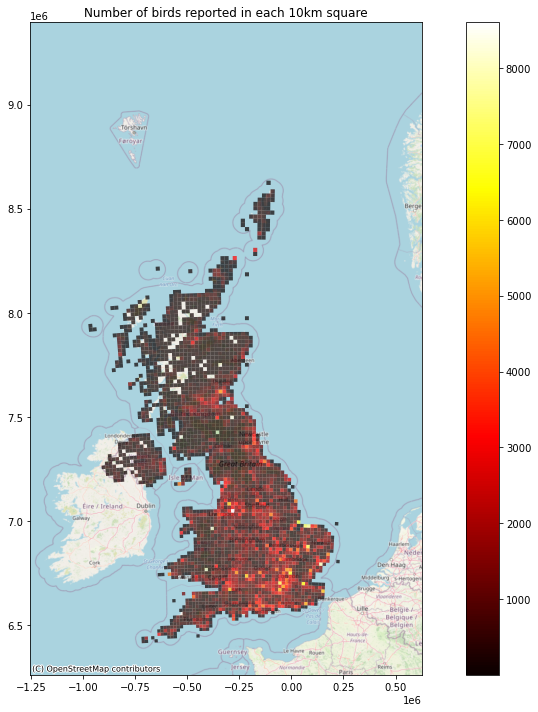

In [12]:
ax = OS10kmCoordinates.plot(column='n_birds', figsize=(16, 12), edgecolor="none",alpha=0.7,cmap='hot', legend=True)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,crs="EPSG:3857",zoom="auto")
plt.autoscale(True)
plt.title('Number of birds reported in each 10km square')

Text(0.5, 1.0, 'Number of bird species reported in each 10km square')

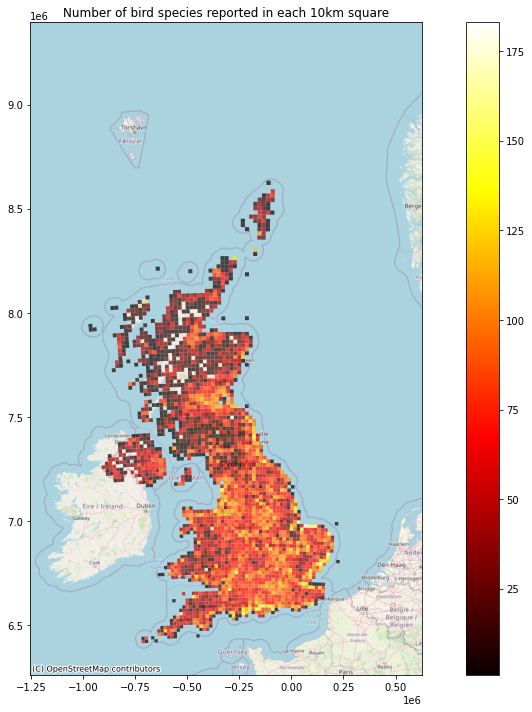

In [11]:
ax = OS10kmCoordinates.plot(column='n_unique_bird_species', figsize=(16, 12), edgecolor="none",alpha=0.7,cmap='hot', legend=True)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,crs="EPSG:3857",zoom="auto")
plt.autoscale(True)
plt.title('Number of bird species reported in each 10km square')

# Get county information
Now let's summarise the gridded data by county region.
We'll grab the shapefiles for the Ceremonial ("Watsonian") county boundaries from the Ordnandce Survey website:
https://www.ordnancesurvey.co.uk/business-and-government/help-and-support/products/boundary-line.html
Make sure to download the .geojson fie. Here, I've extracted it to a subfolder called 'mapping'.

We'll use Geopandas spatial join  (sjoin) and groupby functions again to collect the observation and count data:

In [14]:
## load in County level boundary (OS data)

boundaries_WGS84= gpd.read_file('../Mapping/bdline_gpkg_gb/data/counties.geojson')
boundaries_WGS84 = boundaries_WGS84.to_crs("EPSG:3857")

# Spatial Join the spatial county boundary information with the gridded data
boundary_species = gpd.sjoin(boundaries_WGS84, OS10kmCoordinates)
boundary_species = boundary_species.drop(labels=['Area_Description'], axis=1)

# observation count per species for each boundary area
counties_grouped = boundary_species.groupby(['Name'])['n_unique_bird_species'].count()
species_prevalence = boundaries_WGS84.join(counties_grouped, on='Name')

/Users/domansa/opt/anaconda3/envs/GIS/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# plot the counties as a species biodiversity heatmap
Now, we can ask which counties have the largest number of different species. Let's plot a chloropleth chart:

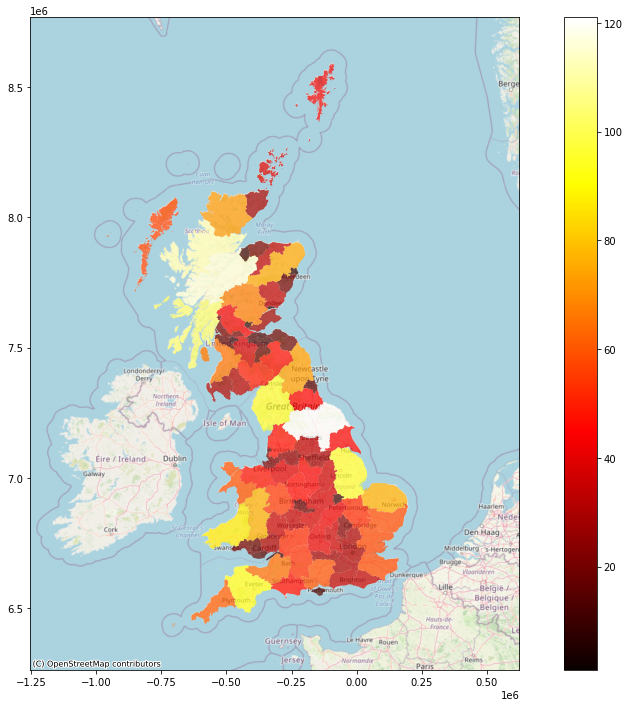

In [16]:
ax = species_prevalence.plot(column='n_unique_bird_species', figsize=(16, 12), cmap='hot', edgecolor="none",alpha=0.7, legend=True)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,crs="EPSG:3857",zoom="auto")
plt.autoscale(True)

# Sort the counties in the UK in descending order by number of unique bird species observations
We will revert the Geopandas dataframe to a Pandas dataframe, and drop the geometry column:

In [57]:
species_prevalenceSorted = species_prevalence.sort_values(by='n_unique_bird_species',ascending=False)
species_prevalenceSorted = pd.DataFrame(species_prevalenceSorted.drop(columns='geometry'))

# Plot the ranked counties by bird biodiversity
Finally, we'll use Panda's built-in bar plotting function to display the results as a bar chart:

Text(0.5, 1.0, 'UK counties, ranked by 2018-2019 bird biodiversity')

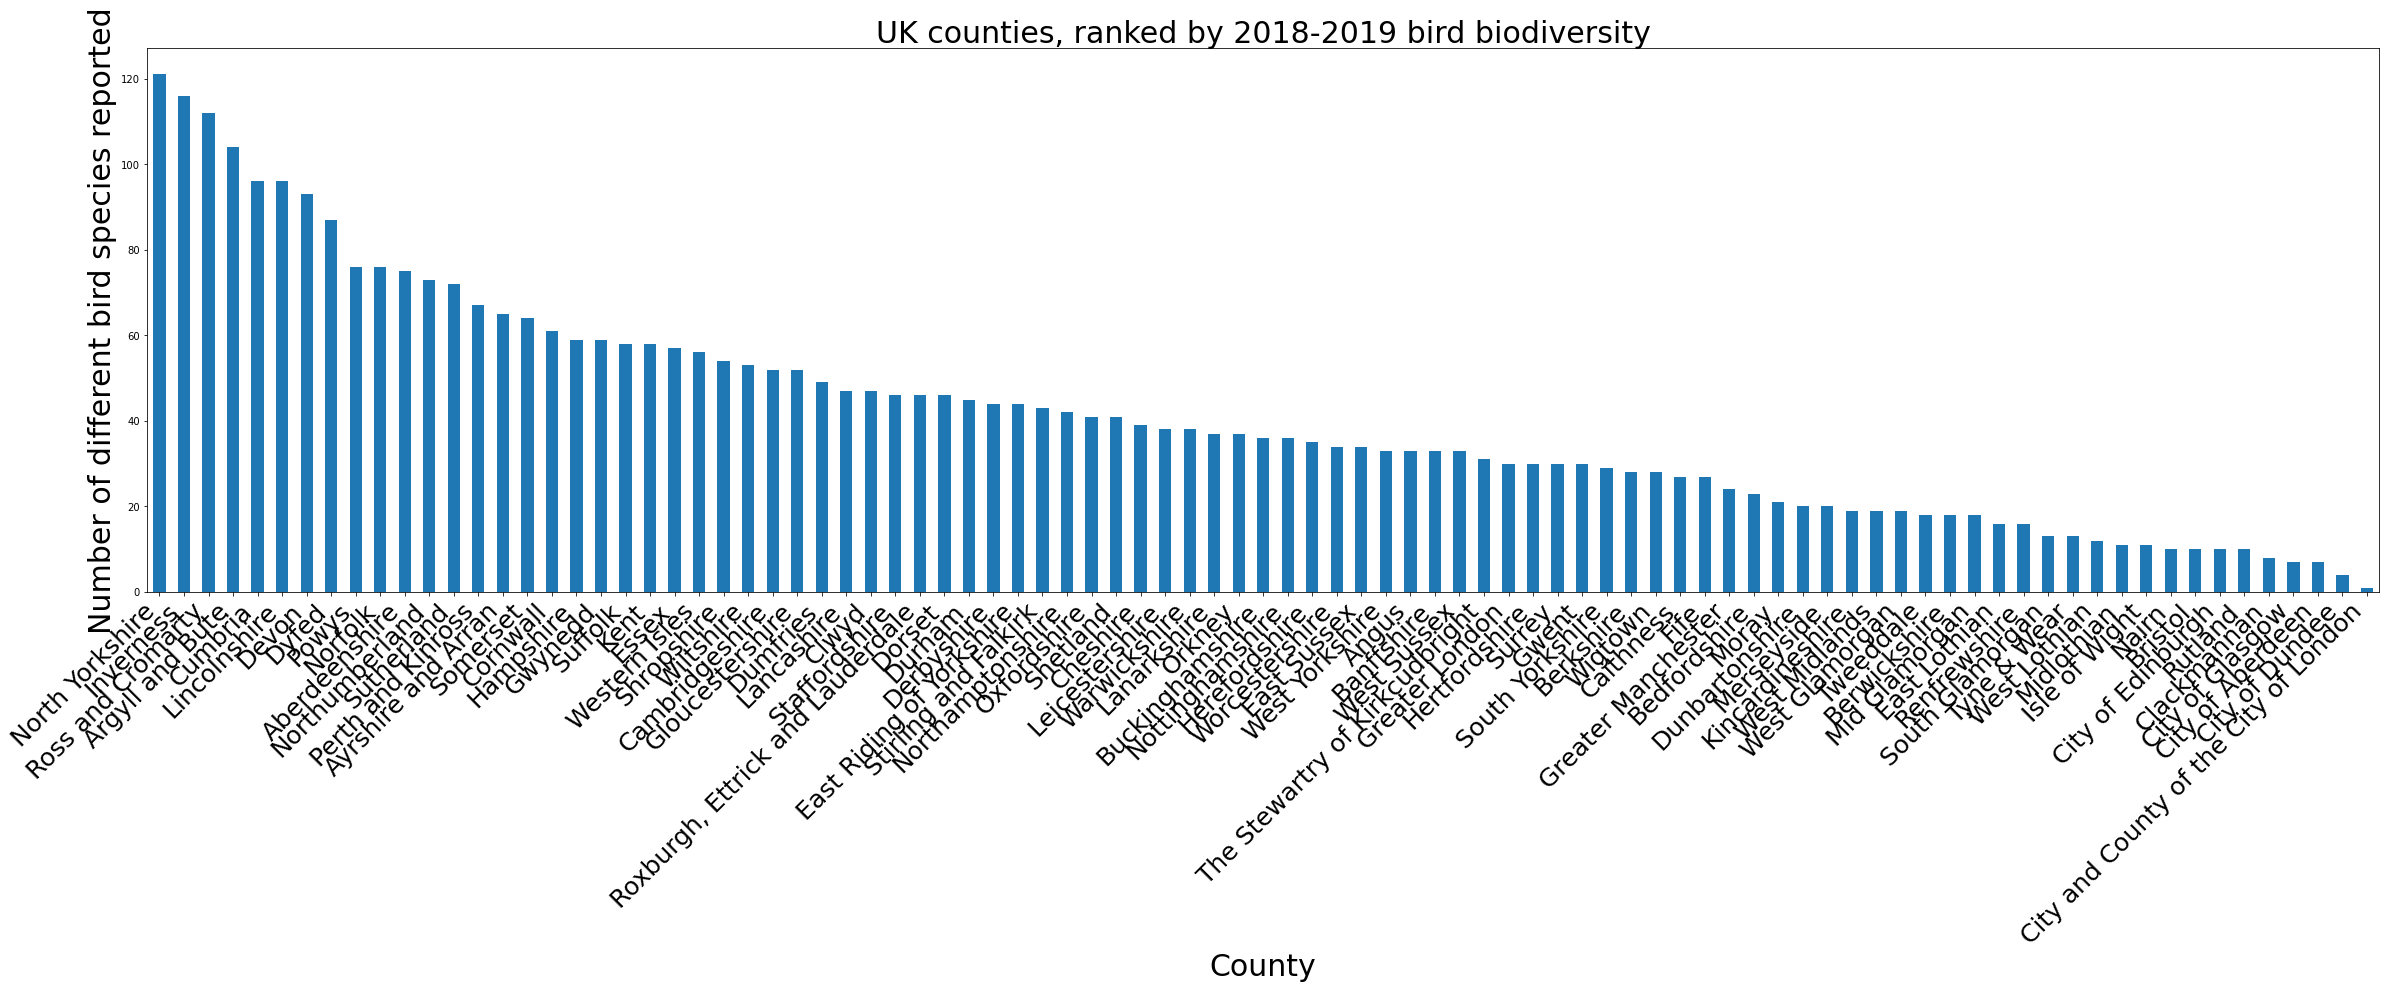

In [62]:
ax = species_prevalenceSorted.plot.bar(x='Name', y='n_unique_bird_species', rot=0,legend=False,figsize=(40, 10));
plt.ylabel('Number of different bird species reported', fontsize=30);
plt.xlabel('County', fontsize=30);
plt.xticks(rotation=45, fontsize=25,ha='right');
plt.title("UK counties, ranked by 2018-2019 bird biodiversity", fontsize=30)